In [1]:
import  tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset import Graph_Classification_Dataset,Inference_Dataset
from sklearn.metrics import r2_score,roc_auc_score

import os
from model import  PredictModel_test,BertModel_test


In [2]:
medium = {'name':'Medium','num_layers': 6, 'num_heads': 8, 'd_model': 256,'path':'medium_weights','addH':True}

In [18]:
arch = medium  ## small 3 4 128   medium: 6 6  256     large:  12 8 516
trained_epoch = 10
num_layers = arch['num_layers']
num_heads = arch['num_heads']
d_model = arch['d_model']
addH = arch['addH']

dff = d_model * 2
vocab_size = 17
dropout_rate = 0.1

seed = 7
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

task = 'Ames'
df = pd.read_csv('data/clf/Ames.txt',sep='\t')
sml_list = df['SMILES'].tolist()
inference_dataset = Inference_Dataset(['Cc1ccc(C(=O)Cl)cc1',
    'COC(=O)C(C)CN=[N+]=[N-]',
    'COc1cc2c(cc1OC)CN(N=O)CC2',
                'Cc1c2ccccc2c(CBr)c2ccccc12',
                'Cc1ccc2nsc(NC(=O)C(Cl)Cl)c2c1',
                'Cc1cc(S(=O)(=O)O)c(N)cc1Cl'
],addH=addH).get_data()

In [19]:
x, adjoin_matrix, smiles ,atom_list = next(iter(inference_dataset.take(1)))
seq = tf.cast(tf.math.equal(x, 0), tf.float32)

mask = seq[:, tf.newaxis, tf.newaxis, :]
model = PredictModel_test(num_layers=num_layers, d_model=d_model, dff=dff, num_heads=num_heads, vocab_size=vocab_size,
                     dense_dropout=0.5)
pred = model(x,mask=mask,training=True,adjoin_matrix=adjoin_matrix)
model.load_weights('classification_weights/Ames_7.h5')

In [20]:
x, adjoin_matrix, smiles ,atom_list = next(iter(inference_dataset.take(1)))
seq = tf.cast(tf.math.equal(x, 0), tf.float32)
mask = seq[:, tf.newaxis, tf.newaxis, :]
x,atts,xs= model(x,mask=mask,training=True,adjoin_matrix=adjoin_matrix)

In [21]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG,display
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

In [22]:

def plot_weights(smiles,attention_plot,max=5):
    mol = Chem.MolFromSmiles(smiles_plot)
    mol = Chem.RemoveHs(mol)
    num_atoms = mol.GetNumAtoms()
    atoms = []

    for i in range(num_atoms):
        atom = mol.GetAtomWithIdx(i)
        atoms.append(atom.GetSymbol()+str(i))


    att = tf.reduce_mean(tf.reduce_mean(attentions_plot[:,:,0,:],axis=0),axis=0)[1:].numpy()

    
    indices = (-att).argsort()
    highlight = indices.tolist()
    print([[atoms[indices[i]],('%.2f'%att[indices[i]])] for i in range(len(indices))])


    drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
    opts = drawer.drawOptions()
    drawer.drawOptions().updateAtomPalette({k: (0, 0, 0) for k in DrawingOptions.elemDict.keys()})


#     for i in range(mol.GetNumAtoms()):
#         opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()
       
    colors = {}
    for i,h in enumerate(highlight):
        colors[h] = (1-0.0*(att[h]-att[highlight[-1]])/(att[highlight[0]]-att[highlight[-1]]),
                     0.9-0.9*(att[h]-att[highlight[-1]])/(att[highlight[0]]-att[highlight[-1]]),
                     0.9-0.9*(att[h]-att[highlight[-1]])/(att[highlight[0]]-att[highlight[-1]]))
    drawer.DrawMolecule(mol,
                        highlightAtoms = highlight,
                        highlightAtomColors=colors,
                        highlightBonds=[])
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    display(SVG(svg))

[['C5', '0.18'], ['Cl7', '0.11'], ['C0', '0.09'], ['O6', '0.09'], ['C3', '0.05'], ['C1', '0.05'], ['C8', '0.04'], ['C4', '0.03'], ['C2', '0.03'], ['C9', '0.03']]


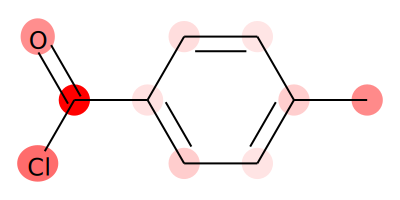

tf.Tensor(
[[ 4.372683 ]
 [ 2.9014668]
 [ 2.0431519]
 [ 0.6779646]
 [ 2.174057 ]
 [-3.0374727]], shape=(6, 1), dtype=float32)


In [23]:


i = 0
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)
smiles_plot
print(x)

[['N8', '0.12'], ['C2', '0.11'], ['N7', '0.11'], ['N9', '0.10'], ['C0', '0.06'], ['C5', '0.06'], ['O3', '0.05'], ['C4', '0.04'], ['C6', '0.03'], ['O1', '0.03']]


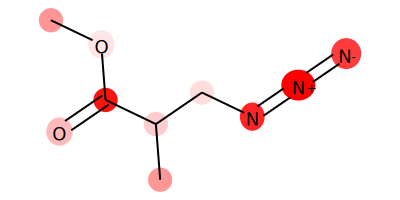

In [24]:
i = 1
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

[['N12', '0.10'], ['N11', '0.10'], ['C10', '0.05'], ['O13', '0.05'], ['C0', '0.05'], ['C7', '0.04'], ['C9', '0.04'], ['C2', '0.04'], ['C4', '0.04'], ['C3', '0.04'], ['C6', '0.03'], ['C14', '0.03'], ['C5', '0.02'], ['O1', '0.02'], ['C15', '0.02'], ['O8', '0.02']]


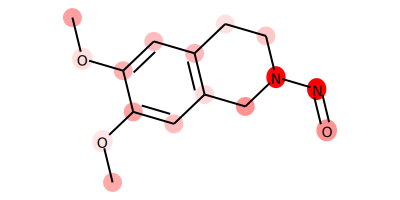

In [25]:
i = 2
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

[['Br10', '0.12'], ['C0', '0.07'], ['C1', '0.06'], ['C8', '0.05'], ['C13', '0.04'], ['C9', '0.04'], ['C5', '0.04'], ['C14', '0.04'], ['C4', '0.03'], ['C11', '0.03'], ['C7', '0.02'], ['C12', '0.02'], ['C15', '0.02'], ['C2', '0.02'], ['C16', '0.02'], ['C6', '0.02'], ['C3', '0.02']]


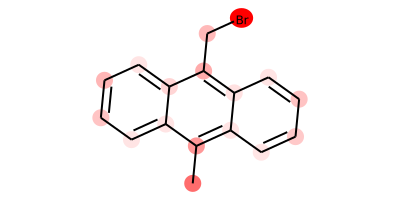

In [16]:
i = 3
smiles_plot = smiles[i].numpy().tolist()[0].decode()
mol = Chem.MolFromSmiles(smiles_plot)
num_atoms = mol.GetNumAtoms()
attentions_plot = tf.concat([att[i:(i+1),:,:num_atoms+1,:num_atoms+1] for att in atts],axis=0)
plot_weights(smiles_plot,attentions_plot)

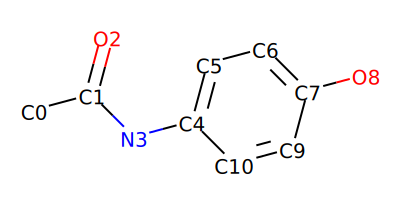

In [17]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles( 'CC(=O)Nc1ccc(O)cc1')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))
##2

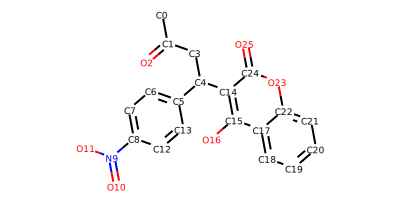

In [13]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles( 'CC(=O)CC(c1ccc([N+](=O)[O-])cc1)c1c(O)c2ccccc2oc1=O')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))
##1

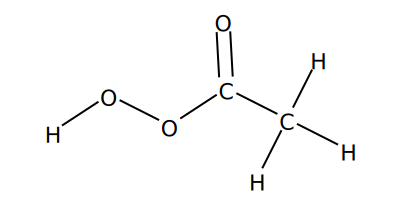

In [14]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
drawer.drawOptions().updateAtomPalette({k: (0, 0, 0) for k in DrawingOptions.elemDict.keys()})
mol = Chem.MolFromSmiles( 'CC(=O)OO')#CC(=O)c1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1
mol = Chem.AddHs(mol)
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##5

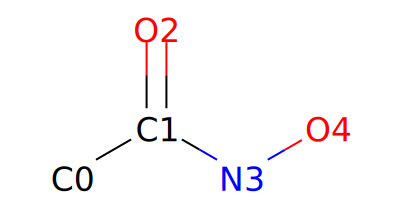

In [10]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles('CC(=O)NO')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##6

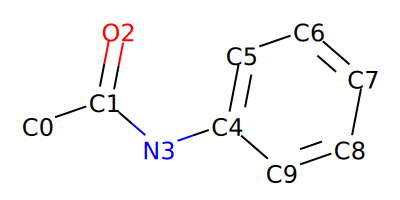

In [11]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles('CC(=O)Nc1ccccc1')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##3

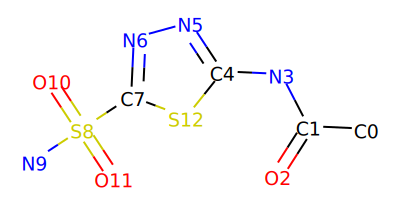

In [12]:
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
opts = drawer.drawOptions()
mol = Chem.MolFromSmiles('CC(=O)Nc1nnc(S(N)(=O)=O)s1')
for i in range(mol.GetNumAtoms()):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)

drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
display(SVG(svg))

##4